In [311]:
# импорт библиотек для работы с табличными данными и базой данных
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
import sqlite3

In [370]:
import scipy.stats

In [281]:
# импорт библиотек для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [172]:
# импорт библиотек для сбора данных 
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import time

In [4]:
# подключение к базе данных
connection = sqlite3.connect('apartments.db')
# создание объекта подключения
cursor = connection.cursor()
print("База данных успешно подключена к SQLite")

База данных успешно подключена к SQLite


In [5]:
# вывод наименований таблиц в базе данных apartments.db
cursor.execute('SELECT name from sqlite_master where type= "table"')
print(cursor.fetchall())

[('as_price_val',), ('as_seller_type',), ('as_history',), ('as_seller_info',), ('as_house_type',), ('as_info',)]


## EDA динамики стоимости продаж и просмотров объявлений по продаже квартир

In [6]:
# вывод наименований переменных в таблице as_history
cursor.execute("PRAGMA table_info('as_history')")
as_history = [name[1] for name in cursor.fetchall()]
print(as_history)

['marker_id', 'price', 'val_id', 'views', 'date']


In [7]:
# закрытие соединения с базой данных
#connection.close()

* ## извлечение данных

In [14]:
# получение данных динамики цен и просмотров (таблица as_history)
cursor.execute("SELECT * FROM as_history;")
as_history = cursor.fetchall()
cursor.execute("PRAGMA table_info('as_history')")
colnames = [name[1] for name in cursor.fetchall()]
as_history_df = pd.DataFrame(data=as_history, columns=colnames)

In [15]:
# проверка получения и вывод данных
as_history_df.head()

,marker_id,price,val_id,views,date
0,2336073418,3270000,1,1505.0,2022-03-16
1,2336387251,4150000,1,1291.0,2022-03-16
2,2335422701,7200000,1,660.0,2022-03-16
3,2282823871,3560000,1,1149.0,2022-03-16
4,2177809978,4256000,1,8262.0,2022-03-16


In [16]:
# проверка типа данных и их полноты 
as_history_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11071 entries, 0 to 11070
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marker_id  11071 non-null  int64  
 1   price      11071 non-null  int64  
 2   val_id     11071 non-null  int64  
 3   views      11063 non-null  float64
 4   date       11071 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 432.6+ KB


* ## проверка наличия пропуска в данных

In [282]:
# количество пропусков по переменным 
as_history_df.isna().sum()

marker_id    0
price        0
val_id       0
views        0
date         0
dtype: int64

In [18]:
# получение данных количества пропусков по переменным (таблица as_history)
cursor.execute("SELECT COUNT(*) - COUNT(marker_id) AS marker_id_null, \
                       COUNT(*) - COUNT(price) AS price_null, \
                       COUNT(*) - COUNT(val_id) AS val_id_null, \
                       COUNT(*) - COUNT(views) AS views_null, \
                       COUNT(*) - COUNT(date) AS date_null \
                       FROM as_history;")
as_history_isna = cursor.fetchall()
index = ['marker_id_null', 'price_null', 'val_id_null', 'views_null', 'date_null']
as_history_df_isna = pd.DataFrame(np.array(as_history_isna).reshape((5,1)), index=index, columns=['isna'])
as_history_df_isna

,isna
marker_id_null,0
price_null,0
val_id_null,0
views_null,8
date_null,0


Обнаружено 8 (восемь) пропусков в данных по просмотрам

* ## заполнение пропусков

In [39]:
# выборка объявлений с отсутствующими данными по просмотрам
as_history_df[as_history_df['views'].isna()]

,marker_id,price,val_id,views,date
7,2380123649,3400000,1,NaN,2022-03-16
9,2338780436,4750130,1,NaN,2022-03-16
1146,2359623437,2770000,1,NaN,2022-03-21
7512,2281928636,2100000,1,NaN,2022-04-11
9001,2393180112,2550000,1,NaN,2022-04-14
9052,2383890528,3160000,1,NaN,2022-04-14
9853,2367425852,1680000,1,NaN,2022-04-15
10232,2391226934,3000000,1,NaN,2022-04-18


In [41]:
# выборка id объявлений с пропусками по просмотрам
marker_id_views_isna = as_history_df[as_history_df['views'].isna()]['marker_id']
marker_id_views_isna

7        2380123649
9        2338780436
1146     2359623437
7512     2281928636
9001     2393180112
9052     2383890528
9853     2367425852
10232    2391226934
Name: marker_id, dtype: int64

In [42]:
# выборка объявлений с пропусками по просмотрам
marker_id_views_isna_df = as_history_df[as_history_df['marker_id'].isin(marker_id_views_isna)]
marker_id_views_isna_df.head()

,marker_id,price,val_id,views,date
7,2380123649,3400000,1,NaN,2022-03-16
9,2338780436,4750130,1,NaN,2022-03-16
57,2367425852,1750000,1,122.0,2022-03-16
175,2281928636,1850000,1,4430.0,2022-03-16
392,2367425852,1750000,1,191.0,2022-03-17


In [43]:
# выборка id объявлений с пропусками по просмотрам
cursor.execute("SELECT DISTINCT marker_id \
                FROM as_history \
                WHERE views IS NULL;")
marker_id = cursor.fetchall()
colnames = ['marker_id']
marker_id_views_isna_sql = pd.DataFrame(data=marker_id, columns=colnames)
marker_id_views_isna_sql

,marker_id
0,2380123649
1,2338780436
2,2359623437
3,2281928636
4,2393180112
5,2383890528
6,2367425852
7,2391226934


In [44]:
# получение данных объявлений с пропусками по просмотрам
cursor.execute("SELECT marker_id, views, date \
                FROM as_history \
                WHERE marker_id IN (SELECT DISTINCT marker_id \
                                    FROM as_history \
                                    WHERE views IS NULL) \
                ORDER BY marker_id, date;")
marker_id_views_isna = cursor.fetchall()
colnames = ['marker_id', 'views', 'date']
marker_id_views_isna_df_sql = pd.DataFrame(data=marker_id_views_isna, columns=colnames)

In [45]:
# проверка получения данных динамики цен и просмотров по id где есть пропуски данных по просмотрам
marker_id_views_isna_df_sql.head()

,marker_id,views,date
0,2281928636,4430.0,2022-03-16
1,2281928636,4449.0,2022-03-17
2,2281928636,4472.0,2022-03-18
3,2281928636,4687.0,2022-03-21
4,2281928636,4752.0,2022-03-22


In [47]:
# проверка соответствия запросов
marker_id_views_isna_df.shape[0] == marker_id_views_isna_df_sql.shape[0]

True

In [48]:
# заполнение пропусков по просмотрам 0 для анализа
marker_id_views_isna_df = marker_id_views_isna_df.fillna(0)

In [49]:
# проверка гипотезы - объявление было только опубликовано или снято с публикации
pd.pivot_table(marker_id_views_isna_df, index='date', columns='marker_id', values='views', fill_value='-')

marker_id,2281928636,2338780436,2359623437,2367425852,2380123649,2383890528,2391226934,2393180112
date,,,,,,,,
2022-03-16,4430.0,0.0,-,122.0,0.0,-,-,-
2022-03-17,4449.0,267.0,-,191.0,154.0,-,-,-
2022-03-18,4472.0,273.0,300.0,-,180.0,-,-,-
2022-03-21,4687.0,289.0,0.0,416.0,285.0,-,-,-
2022-03-22,4752.0,294.0,-,463.0,311.0,-,-,-
2022-03-23,4856.0,301.0,-,474.0,331.0,-,-,-
2022-03-24,4917.0,-,-,521.0,406.0,-,-,-
2022-03-25,4934.0,306.0,-,553.0,450.0,-,-,-
2022-03-28,5011.0,-,-,610.0,493.0,-,-,-


Из данных видно, что по id 2338780436, 2359623437, 2367425852, 2380123649 и 2391226934 \
нет данных по просмотрам в день публикации объявления или снятия с публикации, \
а по id 2281928636, 2383890528 и 2359623437 в течение публикации.

In [50]:
# выборка даты публикации и снятия с публикации соответствующего объявления
date_views_isna_df = marker_id_views_isna_df_sql.groupby('marker_id')['date'] \
                                                .agg(['min', 'max']) \
                                                .rename(columns={'min' : 'min_data', 'max' : 'max_data'}) \
                                                .reset_index()                     
date_views_isna_df

,marker_id,min_data,max_data
0,2281928636,2022-03-16,2022-04-19
1,2338780436,2022-03-16,2022-04-14
2,2359623437,2022-03-18,2022-03-21
3,2367425852,2022-03-16,2022-04-15
4,2380123649,2022-03-16,2022-04-19
5,2383890528,2022-04-06,2022-04-19
6,2391226934,2022-04-18,2022-04-19
7,2393180112,2022-04-11,2022-04-19


In [51]:
# получение даты публикации и снятия с публикации соответствующего объявления
cursor.execute("SELECT marker_id, MIN(date) AS min_data, MAX(date) AS max_date \
                FROM as_history \
                WHERE marker_id IN (SELECT DISTINCT marker_id \
                                    FROM as_history \
                                    WHERE views IS NULL) \
                GROUP BY marker_id;")
date_views_isna = cursor.fetchall()
colnames = ['marker_id', 'min_data', 'max_date']
date_views_isna_df_sql = pd.DataFrame(data=date_views_isna, columns=colnames)
date_views_isna_df_sql

,marker_id,min_data,max_date
0,2281928636,2022-03-16,2022-04-19
1,2338780436,2022-03-16,2022-04-14
2,2359623437,2022-03-18,2022-03-21
3,2367425852,2022-03-16,2022-04-15
4,2380123649,2022-03-16,2022-04-19
5,2383890528,2022-04-06,2022-04-19
6,2391226934,2022-04-18,2022-04-19
7,2393180112,2022-04-11,2022-04-19


In [52]:
# сортировка данных для заполнения пропусков
as_history_df.sort_values(by=['marker_id', 'date'], inplace=True)

In [53]:
# переназначение индекса после сортировки
as_history_df.reset_index(drop=True, inplace=True)

In [54]:
""" заполнение пропусков в цикле по условию - в день публикации объявления количество просмотров 0, 
    в день снятия c публикации количество просмотров равно количеству просмотров в предыдущий день """

for row in range(len(date_views_isna_df)):
    marker_id, min_data, max_data = date_views_isna_df.iloc[row]
    if as_history_df[(as_history_df['marker_id'] == marker_id) & (as_history_df['date'] == min_data)]['views'].isna().values[0]:
        i = as_history_df[(as_history_df['marker_id'] == marker_id) & (as_history_df['date'] == min_data)]['views'].index[0]
        as_history_df['views'][i] = 0
    if as_history_df[(as_history_df['marker_id'] == marker_id) & (as_history_df['date'] == max_data)]['views'].isna().values[0]:
        i = as_history_df[(as_history_df['marker_id'] == marker_id) & (as_history_df['date'] == max_data)]['views'].index[0]
        as_history_df['views'][i] = as_history_df['views'][i - 1]   

<ipython-input-54-6384bc118321>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  as_history_df['views'][i] = 0
<ipython-input-54-6384bc118321>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  as_history_df['views'][i] = as_history_df['views'][i - 1]
<ipython-input-54-6384bc118321>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  as_history_df['views'][i] = as_history_df['views'][i - 1]
<ipython-input-54-6384bc118321>:8: SettingWithCo

In [55]:
# пример внесения изменений в базу данных
cursor.execute("SELECT * FROM as_history WHERE marker_id = ? AND date = ?;", (2338780436, '2022-03-16'))
cursor.fetchall()

[(2338780436, 4750130, 1, None, '2022-03-16')]

In [56]:
# внесение изменений в базу данных
cursor.execute("UPDATE as_history SET views = ? WHERE marker_id = ? AND date = ?;", (0, 2338780436, '2022-03-16'))
connection.commit()

In [57]:
# пример внесения изменений в базу данных
cursor.execute("SELECT * FROM as_history WHERE marker_id = ? AND date = ?;", (2338780436, '2022-03-16'))
cursor.fetchall()

[(2338780436, 4750130, 1, 0, '2022-03-16')]

In [58]:
# проверка заполнение пропусков
as_history_df.isna().sum()

marker_id    0
price        0
val_id       0
views        3
date         0
dtype: int64

In [59]:
""" заполнение оставшихся пропусков (в течение публикации объявления) средним значением 
         количества просмотров в предшествующий день и следующий день публикациии """

as_history_df['views'].interpolate(inplace=True)

In [60]:
# проверка заполнение пропусков
as_history_df.isna().sum()

marker_id    0
price        0
val_id       0
views        0
date         0
dtype: int64

In [61]:
# преобразование типа данных 
as_history_df['date'] = pd.to_datetime(as_history_df['date'])
as_history_df = as_history_df.astype({'views': "int64"})

In [62]:
# проверка преобразования типа данных
as_history_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11071 entries, 0 to 11070
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   marker_id  11071 non-null  int64         
 1   price      11071 non-null  int64         
 2   val_id     11071 non-null  int64         
 3   views      11071 non-null  int64         
 4   date       11071 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4)
memory usage: 432.6 KB


In [63]:
# запись предобработанных данных в файл
as_history_df.to_csv('as_history.csv', encoding='utf-8', index=False)

In [64]:
# проверка записи данных в файл, вывод данных
as_history_df = pd.read_csv('as_history.csv', parse_dates=['date'], encoding='utf-8')
as_history_df.head()

,marker_id,price,val_id,views,date
0,389475304,2950000,1,344,2022-04-18
1,389475304,2950000,1,440,2022-04-19
2,600204697,1500000,1,1127,2022-03-17
3,600204697,1500000,1,1156,2022-03-18
4,600204697,1500000,1,1259,2022-03-21


* ## первичный анализ данных

In [65]:
# период за который были собраны данные
start_date = as_history_df['date'].dt.date.min()
last_date = as_history_df['date'].dt.date.max()
print(f'Данные по динамике стоимости и просмотрам объявлений квартир в г. Зеленодольск собраны с {start_date} по {last_date}')

Данные по динамике стоимости и просмотрам объявлений квартир в г. Зеленодольск собраны с 2022-03-16 по 2022-04-19


In [66]:
# получения периода за который были собраны данные
cursor.execute("SELECT MIN(date) AS min_data, MAX(date) AS max_date \
                FROM as_history;")
date_info = cursor.fetchall()
start_date = date_info[0][0]
last_date = date_info[0][1]
print(f'Данные по динамике стоимости и просмотрам объявлений квартир в г. Зеленодольск собраны с {start_date} по {last_date}')

Данные по динамике стоимости и просмотрам объявлений квартир в г. Зеленодольск собраны с 2022-03-16 по 2022-04-19


In [67]:
# количество квартир в базе данных
as_history_df['marker_id'].nunique()

961

In [68]:
# количество квартир в базе данных
cursor.execute("SELECT COUNT(DISTINCT marker_id) \
                FROM as_history;")
cursor.fetchmany(1)[0][0]

961

В базе данных собрана информация по 961 квартире

In [71]:
# количество дней публикации по объявлениям, средняя стоимость продажи в период публикации и итоговое количество просмотров
marker_id_df = as_history_df.groupby('marker_id', as_index=False) \
                            .agg({'price' : 'mean', 'views' : np.max, 'date' : 'count'}) \
                            .rename(columns={"price" : "avg_price", 'views' : 'max_views', 'date' : "count_date"})
marker_id_df.head()

,marker_id,avg_price,max_views,count_date
0,389475304,2950000.0,440,2
1,600204697,1500000.0,1511,23
2,671949391,4970000.0,8036,13
3,700241877,2000000.0,823,12
4,1133382367,6100000.0,11838,11


In [72]:
# количество дней публикации по объявлениям, средняя стоимость продажи в период публикации и итоговое количество просмотров
cursor.execute("SELECT marker_id, AVG(price) AS AVG_price, MAX(views) AS views, COUNT(date) AS COUNT_date \
                FROM as_history \
                GROUP BY marker_id;")
marker_id = cursor.fetchall()
colnames = ["marker_id", "avg_price", "max_views", "count_date"]
marker_id_df_sql = pd.DataFrame(data=marker_id, columns=colnames)
marker_id_df_sql.head()

,marker_id,avg_price,max_views,count_date
0,389475304,2950000.0,440,2
1,600204697,1500000.0,1511,23
2,671949391,4970000.0,8036,13
3,700241877,2000000.0,823,12
4,1133382367,6100000.0,11838,11


In [74]:
# настройка отображения чисел
pd.options.display.float_format ='{:,.2f}'.format

In [77]:
# статистика по дням публикации
marker_id_df[["avg_price", "max_views", "count_date"]].describe()

,avg_price,max_views,count_date
count,961.00,961.00,961.00
mean,"3,737,016.67","1,400.12",11.52
std,"1,368,938.02","1,863.82",7.91
min,"351,000.00",0.00,1.00
25%,"2,850,000.00",212.00,5.00
50%,"3,700,000.00",790.00,10.00
75%,"4,471,428.57","1,739.00",19.00
max,"10,500,000.00","11,838.00",25.00


Собраны данные по 961 квартире \
В среднем продолжительность публикации объявления о продаже квартиры 10 дней \
Объявления, которые публиковались 1 день имеют 0 просмотров \
Есть квартиры с высокой стоимостью

In [78]:
# сводная статистика по стоимсоти продаж и просмотрам
as_history_df[['price', 'views']].describe()

,price,views
count,"11,071.00","11,071.00"
mean,"3,745,639.87","1,504.36"
std,"1,393,083.08","1,813.09"
min,"1,299.00",0.00
25%,"2,840,000.00",351.00
50%,"3,590,000.00",867.00
75%,"4,460,000.00","1,910.50"
max,"15,000,000.00","11,838.00"


Присутствуют данные с сомнительной стоимостью квартиры (минимальная цена равна 1 299,00 руб.) \
75% квартир имеют стоимость менее 4,5 млн. рублей

* ## анализ стоимости квартир

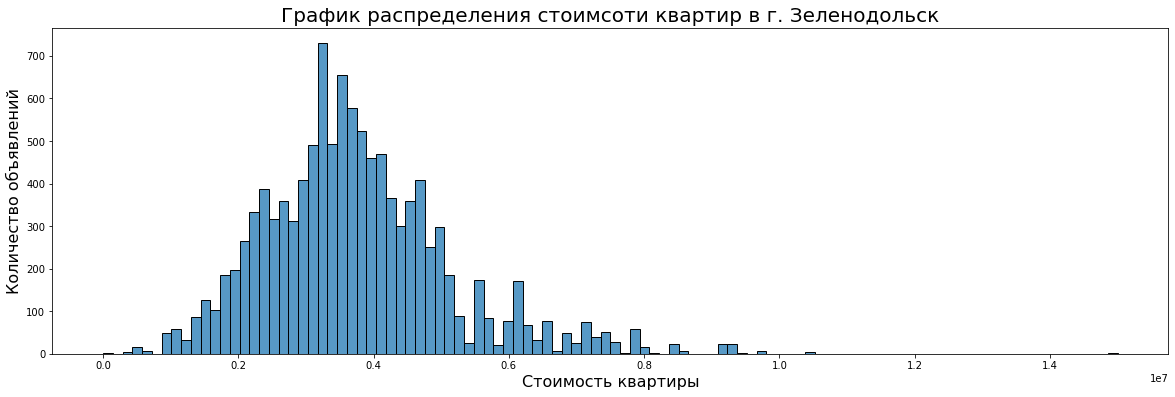

In [82]:
# график распределения стоимсоти продажи квартир в г. Зеленодольск
fig, ax = plt.subplots(figsize=(20,6))
sns.histplot(x=as_history_df['price']) #kde=True
ax.set_title('График распределения стоимсоти квартир в г. Зеленодольск', fontsize=20)
plt.xlabel('Стоимость квартиры', fontsize=16)
plt.ylabel('Количество объявлений', fontsize=16)
plt.show()

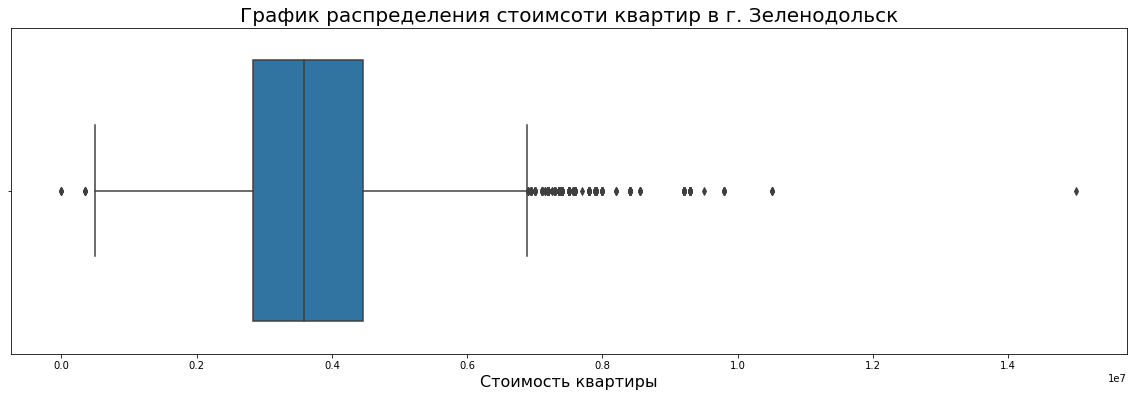

In [84]:
# график распределения стоимсоти продажи квартир в г. Зеленодольск
fig, ax = plt.subplots(figsize=(20,6))
sns.boxplot(x=as_history_df['price'])
ax.set_title('График распределения стоимсоти квартир в г. Зеленодольск', fontsize=20)
plt.xlabel('Стоимость квартиры', fontsize=16)
plt.show()

Из графика видно, что присутствуют выбросы по стоимости продажи квартир. \
Можно сделать предположение, что в данные попали объявления о сдаче квартиры по суточно \
или квартиры с дорогой отделкой и мебелью.

In [85]:
# расчет межквартильного размаха по стоимости 'price'
price_q1 = as_history_df['price'].quantile(0.25)
price_q3 = as_history_df['price'].quantile(0.75)
price_iqr = price_q3 - price_q1

In [86]:
# доверительный интервал по стоимости 'price'
price_iqr_outlier_threshold_bottom = price_q1 - 1.5 * price_iqr
price_iqr_outlier_threshold_up = price_q3 + 1.5 * price_iqr
print(price_iqr_outlier_threshold_bottom)
print(price_iqr_outlier_threshold_up)

410000.0
6890000.0


In [87]:
# вывод наименований переменных в таблице as_info
cursor.execute("PRAGMA table_info('as_info')")
as_info = [name[1] for name in cursor.fetchall()]
print(as_info)

['marker_id', 'href', 'title', 'house_id', 'address', 'seller_id', 'description', 'priority', 'params', 'map_lat', 'map_lon']


In [99]:
# получение id объявлений с выбросами значений стоимости продажи
cursor.execute("SELECT DISTINCT marker_id FROM as_history WHERE price < ? OR price > ?;", \
               (price_iqr_outlier_threshold_bottom, price_iqr_outlier_threshold_up))
cursor.fetchall()

[(2335422701,),
 (2303897172,),
 (2169684764,),
 (2093381022,),
 (2319411844,),
 (2226313413,),
 (2345119573,),
 (2323556055,),
 (2299204813,),
 (2227936855,),
 (2356210729,),
 (2260630965,),
 (2354832351,),
 (2313986158,),
 (2355451420,),
 (1832586213,),
 (2363475665,),
 (2391140491,),
 (2385883672,),
 (2255493594,),
 (2378698736,),
 (2347116162,),
 (2394885504,),
 (2371044851,),
 (2272403365,),
 (2272600258,),
 (2376223141,),
 (2386068006,),
 (2410585307,),
 (1339782339,)]

In [111]:
# получение данных по объявлениям с выбросами данных по стоимости
cursor.execute("SELECT marker_id, href, title, description, MIN(price) AS min_price, \
                       MAX(price) AS max_price, MAX(price) - MIN(price) AS diff_price \
                FROM as_info \
                INNER JOIN as_history USING (marker_id)\
                WHERE marker_id IN (SELECT DISTINCT marker_id FROM as_history WHERE price < ? OR price > ?) \
                GROUP BY marker_id;", \
               (price_iqr_outlier_threshold_bottom, price_iqr_outlier_threshold_up))
query_data = cursor.fetchall()
colnames = ['marker_id', 'href', 'title', 'description', 'min_price', 'max_price', 'diff_price']
release_price_df = pd.DataFrame(data=query_data, columns=colnames)
release_price_df.head()

,marker_id,href,title,description,min_price,max_price,diff_price
0,1339782339,https://www.avito.ru/zelenodolsk/kvartiry/5-k....,"5-к. квартира, 152 м², 5/6 эт.",В продаже очень просторная и уютная 5-ти комна...,8200000,8200000,0
1,1832586213,https://www.avito.ru/zelenodolsk/kvartiry/3-k....,"3-к. квартира, 90 м², 10/11 эт.",Отличная 2-уровневая 3-комнатная улучшенка на ...,7500000,7500000,0
2,2093381022,https://www.avito.ru/zelenodolsk/kvartiry/3-k....,"3-к. квартира, 83 м², 3/5 эт.",Квартира с дорогим ремонтом около санатория Во...,9800000,15000000,5200000
3,2169684764,https://www.avito.ru/zelenodolsk/kvartiry/2-k....,"2-к. квартира, 72 м², 5/6 эт.","Уютная, тёплая, шикарная квартира в спальном т...",7190000,7250000,60000
4,2226313413,https://www.avito.ru/zelenodolsk/kvartiry/4-k....,"4-к. квартира, 102 м², 2/6 эт.",Сделан 6 января 2022 г. Ремонт зала и коридора...,6899999,7590000,690001


In [117]:
# статистика по изменению стоимости с предпологаемыми данными с выбросами 
release_price_df['diff_price'].describe()

count          30.00
mean      281,423.40
std       968,699.59
min             0.00
25%             0.00
50%             0.00
75%        57,500.00
max     5,200,000.00
Name: diff_price, dtype: float64

Есть объявления с изменением стоимости в период публикации более 5_000_000 рублей

In [131]:
# получение данных по объявлениям с максимальной стоимостью
cursor.execute("SELECT marker_id, date, price, views \
                FROM as_history \
                WHERE marker_id = (SELECT marker_id \
                                   FROM as_history \
                                   WHERE price = (SELECT MAX(price) FROM as_history)) \
                ORDER BY date;")
max_price = cursor.fetchall()
colnames = ['marker_id', 'date', 'price', 'views']
max_price_df_sql = pd.DataFrame(data=max_price, columns=colnames)
max_price_df_sql

,marker_id,date,price,views
0,2093381022,2022-03-16,15000000,6066
1,2093381022,2022-04-05,9800000,4460
2,2093381022,2022-04-06,9800000,4460
3,2093381022,2022-04-07,9800000,4464
4,2093381022,2022-04-08,9800000,4472
5,2093381022,2022-04-11,9800000,4487
6,2093381022,2022-04-12,9800000,4492
7,2093381022,2022-04-13,9800000,4496


In [130]:
# дата начала сбора данных
cursor.execute("SELECT MIN(date) \
                FROM as_history ;")
cursor.fetchall()

[('2022-03-16',)]

Как видно максимальная стоимость объявления с marker_id=2093381022 была только 16 марта 2022 года \
И в этот же день оно было снято с публикации \
Количество просмотров при повторной публикации уменьшилось \
Данных с 17 марта по 04 апреля о статистике стоимости и просмотрах отсутствуют.

In [138]:
# индекс в DataFrame с аномальным значением стоимости и просмотрами
index_price_false = as_history_df[as_history_df['price'] == as_history_df['price'].max()].index
index_price_false

Int64Index([488], dtype='int64')

In [139]:
as_history_df[as_history_df['price'] == as_history_df['price'].max()]

,marker_id,price,val_id,views,date
488,2093381022,15000000,1,6066,2022-03-16


In [141]:
# удаление данных с аномальной стоимостью
as_history_df.drop(index=index_price_false, inplace=True)

In [142]:
""" проверка гипотезы - в данные попали объявления о сдаче квартиры по суточно 
            или квартиры с дорогой отделкой и мебелью """

release_price_df['description_sale'] = release_price_df['description'] \
                                       .apply(lambda x: 'дорог' in x.lower() or 'прод' in x.lower())

In [143]:
# количество сомнительных объявлений
release_price_df.query('description_sale == False').shape[0]

7

In [144]:
# вывод объявлений, попавших в выборку
release_price_df.query('description_sale == False')

,marker_id,href,title,description,min_price,max_price,diff_price,description_sale
5,2227936855,https://www.avito.ru/zelenodolsk/kvartiry/3-k....,"3-к. квартира, 77 м², 4/9 эт.",Квартира с индивидуальным отоплением по улице ...,7200000,7200000,0,False
10,2299204813,https://www.avito.ru/zelenodolsk/kvartiry/3-k....,"3-к. квартира, 87,1 м², 1/5 эт.","Дом находится в очень удобном, тихом и спокойн...",7800000,7800000,0,False
16,2345119573,https://www.avito.ru/zelenodolsk/kvartiry/3-k....,"3-к. квартира, 106 м², 4/5 эт.",Дизайнерский ремонт 2021 года. В квартире есть...,9300000,9300000,0,False
18,2354832351,https://www.avito.ru/zelenodolsk/kvartiry/3-k....,"3-к. квартира, 85 м², 7/9 эт.","Просторная трехкомнатная квартира в новом, сда...",7000000,7100000,100000,False
19,2355451420,https://www.avito.ru/zelenodolsk/kvartiry/3-k....,"3-к. квартира, 74 м², 5/10 эт.","Просторная, уютная квартира! Удобное расположе...",6850000,6900000,50000,False
20,2356210729,https://www.avito.ru/zelenodolsk/kvartiry/2-k....,"2-к. квартира, 72 м², 5/9 эт.",Шикарное предложение для тех кто хочет жить в ...,7500000,7500000,0,False
26,2386068006,https://www.avito.ru/zelenodolsk/kvartiry/3-k....,"3-к. квартира, 90 м², 5/5 эт.",Квартира с индивидуальным отоплением в центре ...,7290000,7300000,10000,False


In [145]:
# проверка контекста объявления
release_price_df['description'][10]

'Дом находится в очень удобном, тихом и спокойном месте. Дом трёхподъездный. Квартира в среднем подъезде, окна выходят на обе стороны, светлая и просторная. Все окна заменены на Rehau. Индивидуальное отопление (двух контурный котел) новый мощный газовый котел Baxi экофор на 240м. Кв. Теплые водяные полы везде (трубы из гофрированной нержавейки), даже в сильные морозы котел работает в среднем режиме, радиаторы оставлены на всякий случай, также подключены к системе. Выполнена стяжка пола керамзитом толщиной 200мм, так как под нами сначала цокольный этаж не был заселён. Квартира на первом этаже, но поднято высоко как на втором, под нами цокольный этаж (Центр детского развития). \nПросторный отапливаемый подъезд с отдельным тамбуром. На площадке (этаже) всего две квартиры. \nСо всех сторон спокойные, добропорядочные, дружелюбные соседи. \nВся мебель практически остаётся, нет смысла разбирать и перевозить. \nКухня и гардероб из Ikea. \nИмеется переустройство: объединенный туалет с ванной, о

Можно сделать вывод, что все объявления являются релевантными, \
а наличие выбросов с минимальной стоимостью обусловлено сбоем \
в работе программы при сборе данных или не корректной ценой в объявлении

In [146]:
# получение данных по объявлениям с минимальной стоимостью
cursor.execute("SELECT marker_id, price, date \
                FROM as_history \
                WHERE price = (SELECT MIN(price) FROM as_history);")
query_data = cursor.fetchall()
colnames = ['marker_id', 'price', 'date']
price_min_df = pd.DataFrame(data=query_data, columns=colnames)
price_min_df.head()

,marker_id,price,date
0,2347116162,1299,2022-03-28
1,2347116162,1299,2022-03-29
2,2347116162,1299,2022-03-30


In [147]:
# выборка данных с минимальной стоимостью
as_history_df[as_history_df['price'] == as_history_df['price'].min()]

,marker_id,price,val_id,views,date
6028,2347116162,1299,1,481,2022-03-28
6029,2347116162,1299,1,589,2022-03-29
6030,2347116162,1299,1,722,2022-03-30


In [148]:
# проверим стоимость для данного объявления в другие дни
as_history_df.query('marker_id == 2347116162')

,marker_id,price,val_id,views,date
6027,2347116162,1300000,1,108,2022-03-25
6028,2347116162,1299,1,481,2022-03-28
6029,2347116162,1299,1,589,2022-03-29
6030,2347116162,1299,1,722,2022-03-30
6031,2347116162,1299000,1,813,2022-03-31
6032,2347116162,1299000,1,689,2022-04-01
6033,2347116162,1299000,1,878,2022-04-04
6034,2347116162,1299000,1,912,2022-04-05
6035,2347116162,1299000,1,954,2022-04-06
6036,2347116162,1299000,1,985,2022-04-07


In [149]:
# получение данных по объявлениям с минимальной стоимостью
cursor.execute("SELECT marker_id, price, date \
                FROM as_history \
                WHERE marker_id = (SELECT marker_id \
                                   FROM as_history \
                                   WHERE price = (SELECT MIN(price)  FROM as_history));")
query_data = cursor.fetchall()
colnames = ['marker_id', 'price', 'date']
price_min_df_sql = pd.DataFrame(data=query_data, columns=colnames)
price_min_df_sql.head(10)

,marker_id,price,date
0,2347116162,1300000,2022-03-25
1,2347116162,1299,2022-03-28
2,2347116162,1299,2022-03-29
3,2347116162,1299,2022-03-30
4,2347116162,1299000,2022-03-31
5,2347116162,1299000,2022-04-01
6,2347116162,1299000,2022-04-04
7,2347116162,1299000,2022-04-05
8,2347116162,1299000,2022-04-06
9,2347116162,1299000,2022-04-07


С 28 по 30 марта 2022 г. при сборе данных произошел сбой в программе \
или в объявлении была указана не актуальная цена.

In [151]:
# получаем индексы в Data Frame с минимальной ценой
index_2347116162 = as_history_df.query('price == 1299').index
index_2347116162

Int64Index([6028, 6029, 6030], dtype='int64')

In [152]:
# внесение изменений в Data Frame
for i in index_2347116162:
    as_history_df['price'][i] = as_history_df['price'][i] * 1000  

<ipython-input-152-200347f48784>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  as_history_df['price'][i] = as_history_df['price'][i] * 1000


In [153]:
# проверка внесения изменений в Data Frame
as_history_df['price'].min()

351000

In [154]:
# еще раз проверим корректность данных по стоимости, получаем id объявления
as_history_df[as_history_df['price'] == as_history_df['price'].min()]['marker_id'].unique() 

array([2323556055], dtype=int64)

In [173]:
# получаем ссылку на объявление на сайте www.avito.ru
cursor.execute("SELECT href FROM as_info \
               WHERE marker_id = 2323556055;")
query_data = cursor.fetchall()
url = query_data[0][0]
url

'https://www.avito.ru/zelenodolsk/kvartiry/1-k._kvartira_27m_44et._2323556055'

In [182]:
# активация драйвера браузера
driver = webdriver.Chrome(ChromeDriverManager().install())



====== WebDriver manager ======
Current google-chrome version is 101.0.4951
Get LATEST chromedriver version for 101.0.4951 google-chrome
Driver [C:\Users\rus_k\.wdm\drivers\chromedriver\win32\101.0.4951.41\chromedriver.exe] found in cache
<ipython-input-182-10bc4cdc9a8c>:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


In [183]:
# получение разметки страницы объявления на сайте www.avito.ru
driver.get(url)
time.sleep(6)
main_page = driver.page_source

In [179]:
# направляем запрос по стоимости продажи квартиры
#r = requests.get(url)
#soup = BeautifulSoup(r.text, 'html.parser')

In [187]:
# парсинг стоимости 
soup = BeautifulSoup(main_page, 'html.parser')
soup.find('span', {'class' : 'price-value-main'}).text.rstrip().replace('\xa0', ' ')

AttributeError: 'NoneType' object has no attribute 'text'

Из запроса видно, что объявление с такой ценой существует

In [189]:
# закрытие браузера
driver.quit()

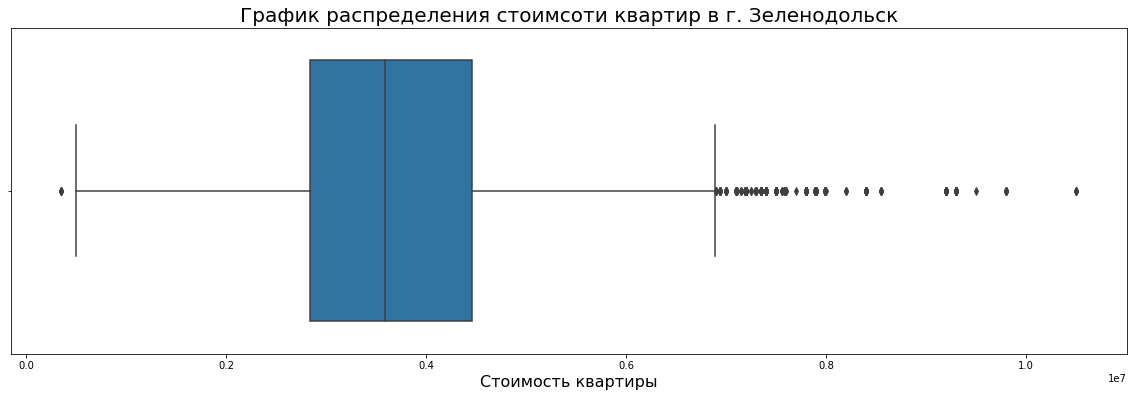

In [196]:
# график распределения стоимсоти продажи квартир в г. Зеленодольск после удаления выброса и корректировки стоимости
fig, ax = plt.subplots(figsize=(20,6))
sns.boxplot(x=as_history_df['price'])
ax.set_title('График распределения стоимсоти квартир в г. Зеленодольск', fontsize=20)
plt.xlabel('Стоимость квартиры', fontsize=16)
plt.show()

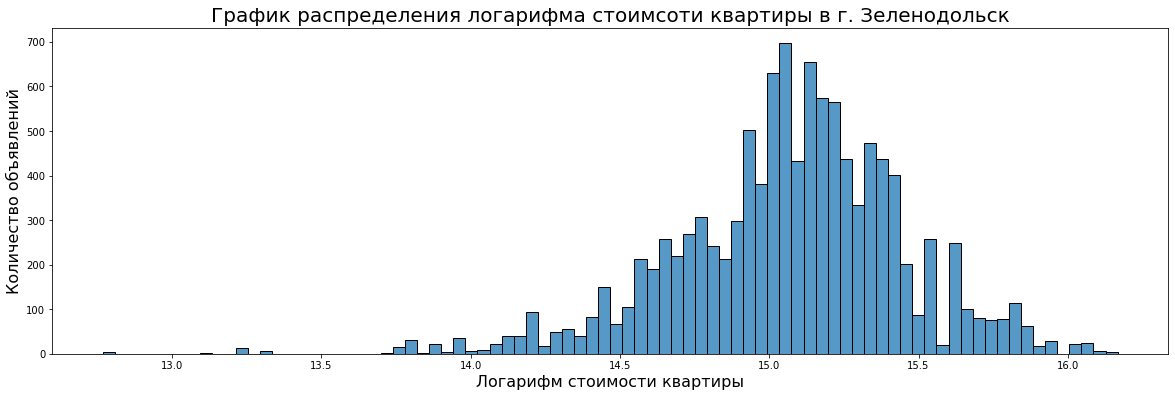

In [255]:
# график распределения стоимсоти продажи квартир в г. Зеленодольск
fig, ax = plt.subplots(figsize=(20,6))
sns.histplot(x=np.log(as_history_df['price'])) #kde=True
ax.set_title('График распределения логарифма стоимсоти квартиры в г. Зеленодольск', fontsize=20)
plt.xlabel('Логарифм стоимости квартиры', fontsize=16)
plt.ylabel('Количество объявлений', fontsize=16)
plt.show()

In [256]:
# запись очишенных данных в файл
as_history_df.to_csv('as_history_clean.csv', encoding='utf-8', index=False)

In [257]:
# проверка записи данных в файл, вывод данных
as_history_df = pd.read_csv('as_history_clean.csv', parse_dates=['date'], encoding='utf-8')
as_history_df.head()

,marker_id,price,val_id,views,date
0,389475304,2950000,1,344,2022-04-18
1,389475304,2950000,1,440,2022-04-19
2,600204697,1500000,1,1127,2022-03-17
3,600204697,1500000,1,1156,2022-03-18
4,600204697,1500000,1,1259,2022-03-21


In [258]:
# получение данных по объявлениям для корректировки стоимости
cursor.execute("SELECT marker_id, price, date FROM as_history WHERE price = (select MIN(price) FROM as_history);")
query_data = cursor.fetchall()
query_data

[(2347116162, 1299, '2022-03-28'),
 (2347116162, 1299, '2022-03-29'),
 (2347116162, 1299, '2022-03-30')]

In [259]:
# внесение изменений в базу данных
#cursor.execute("UPDATE as_history SET price = ? WHERE marker_id = ? AND date = ?;", (query_data[0][1] * 1000, query_data[0][0], query_data[0][2]))
#connection.commit()

In [260]:
# проверка внесения изменений
#cursor.execute("SELECT marker_id, price, date FROM as_history WHERE marker_id = ?;", (query_data[0][0],))
#cursor.fetchall()

In [261]:
# динамика средней стоимости квартир
as_history_price_df = as_history_df.groupby('date')['price'].mean()
as_history_price_df.head()

date
2022-03-16   3,633,400.70
2022-03-17   3,683,004.03
2022-03-18   3,544,069.46
2022-03-21   3,772,133.03
2022-03-22   3,694,638.01
Name: price, dtype: float64

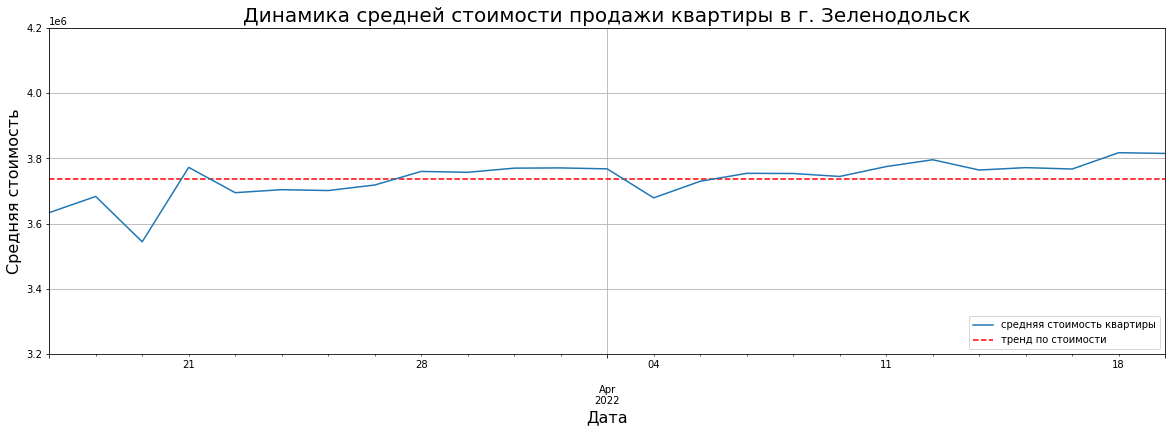

In [262]:
# график динамики средней стоимости квартир
fig, ax = plt.subplots(figsize=(20,6))

ax = as_history_price_df.plot(grid=True, label = 'средняя стоимость квартиры')

ax.set_title('Динамика средней стоимости продажи квартиры в г. Зеленодольск', fontsize=20)
plt.xlabel('Дата', fontsize=16)
plt.ylabel('Средняя стоимость', fontsize=16)


ax.hlines(as_history_price_df.mean(), \
          start_date, last_date, color = 'r', linestyle = '--', label = 'тренд по стоимости')

ax.legend(loc = 'lower right')

plt.ylim(3200000,4200000)

plt.show()

Виден плавный рост средней стоимости продажи квартир. \
Также можно отметить резкое снижение средней стоимости 18 марта и 04 апреля 2022 г.

In [263]:
# дата с минимальным значением средней стоимости продажи квартиры
as_history_price_df[as_history_price_df == as_history_price_df.min()]

date
2022-03-18   3,544,069.46
Name: price, dtype: float64

In [264]:
# статистика стоимсоти 18 марта 2022 года
as_history_df[as_history_df['date'].dt.date == date(2022, 3, 18)]['price'].agg(['min',  'max', 'mean', 'std'])

min      351,000.00
max    9,300,000.00
mean   3,544,069.46
std    1,311,574.38
Name: price, dtype: float64

Как видно в этот день присутствует объявление с минимальной ценой в данных

In [265]:
# период публикации объявления с минимальной ценой
as_history_df[as_history_df['price'] == as_history_df['price'].min()]['date'].agg(['min',  'max'])

min   2022-03-16
max   2022-03-23
Name: date, dtype: datetime64[ns]

* ## анализ количества объявлений

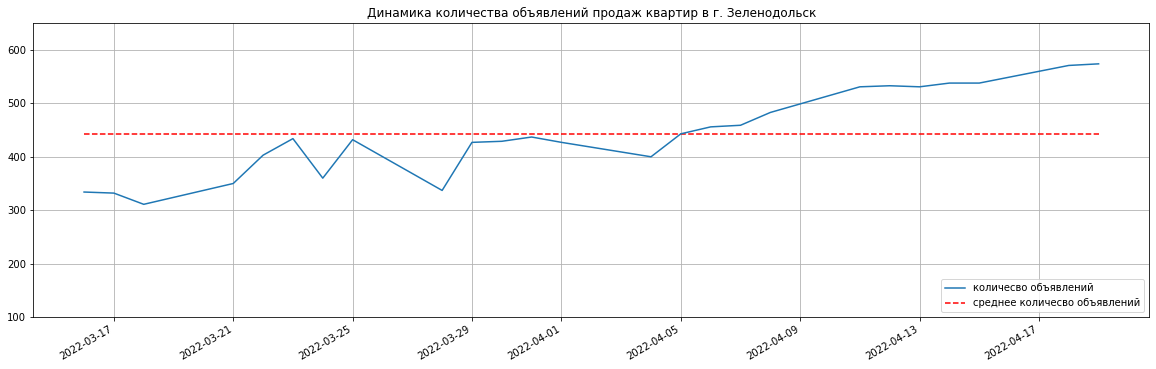

In [266]:
# график динамики количества объвлений 
fig, ax = plt.subplots(figsize=(20,6))

ax = as_history_df['date'].value_counts().plot(grid=True, label = 'количесво объявлений')

ax.set_title('Динамика количества объявлений продаж квартир в г. Зеленодольск')

ax.hlines(as_history_df['date'].value_counts().mean(), \
          start_date, last_date, color = 'r', linestyle = '--', label = 'среднее количесво объявлений')

ax.legend(loc = 'lower right')

plt.ylim(100,650)

plt.show()

С 16 марта по 05 апреля 2022 г. отмечаются резкие колебания по количеству объявлений, \
а с 05 апреля 2022 г. стабильный рост количества объявлений.

* ## анализ количества просмотров

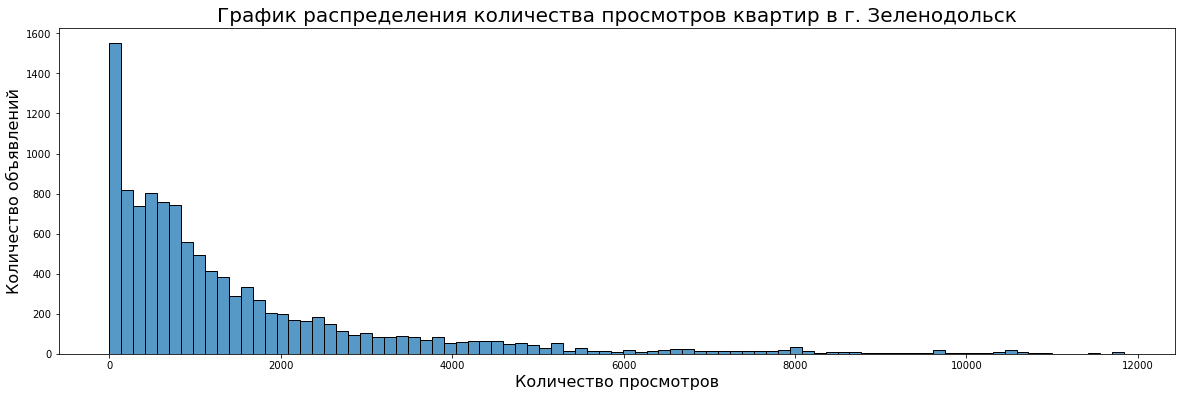

In [296]:
# график динамики количества просмотров
fig, ax = plt.subplots(figsize=(20,6))
sns.histplot(x=as_history_df['views']) #kde=True
ax.set_title('График распределения количества просмотров квартир в г. Зеленодольск', fontsize=20)
plt.xlabel('Количество просмотров', fontsize=16)
plt.ylabel('Количество объявлений', fontsize=16)
plt.show()

Есть небольшое количество квартир с количеством просмотров более чем 5 000 \
Можно предположить, что объявление является привлекательным или долго продаются

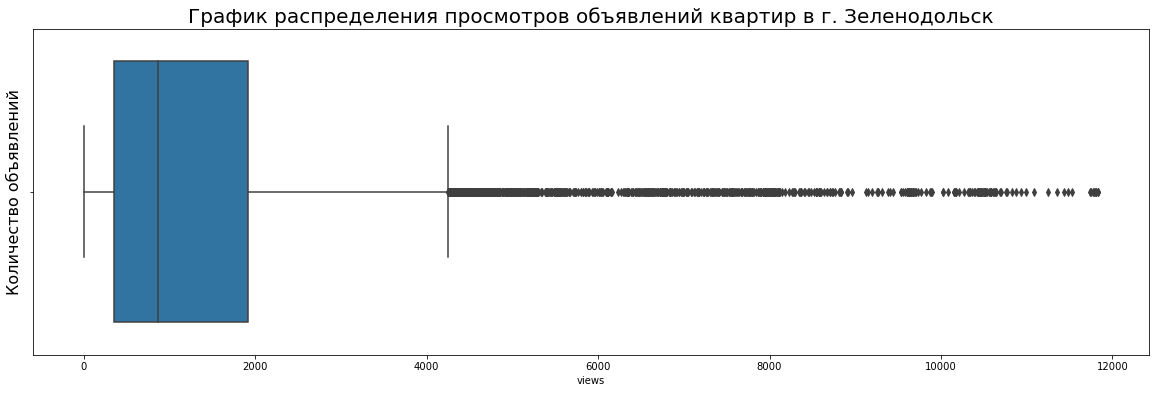

In [285]:
# график распределения стоимсоти продажи квартир в г. Зеленодольск после удаления выброса и корректировки стоимости
fig, ax = plt.subplots(figsize=(20,6))
sns.boxplot(x=as_history_df['views'])
ax.set_title('График распределения просмотров объявлений квартир в г. Зеленодольск', fontsize=20)
plt.ylabel('Количество объявлений', fontsize=16)
plt.show()

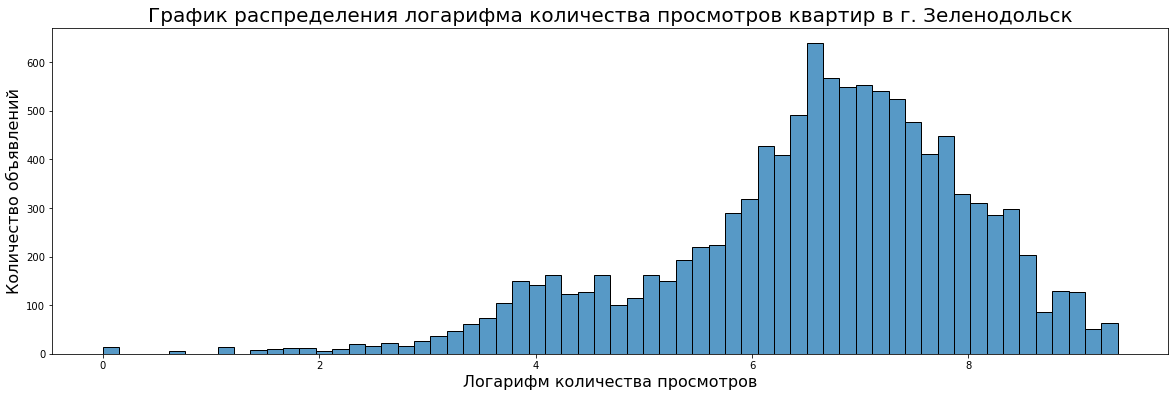

In [284]:
# график распределения стоимсоти продажи квартир в г. Зеленодольск
fig, ax = plt.subplots(figsize=(20,6))
sns.histplot(x=np.log1p(as_history_df['views'])) #kde=True
ax.set_title('График распределения логарифма количества просмотров квартир в г. Зеленодольск', fontsize=20)
plt.xlabel('Логарифм количества просмотров', fontsize=16)
plt.ylabel('Количество объявлений', fontsize=16)
plt.show()

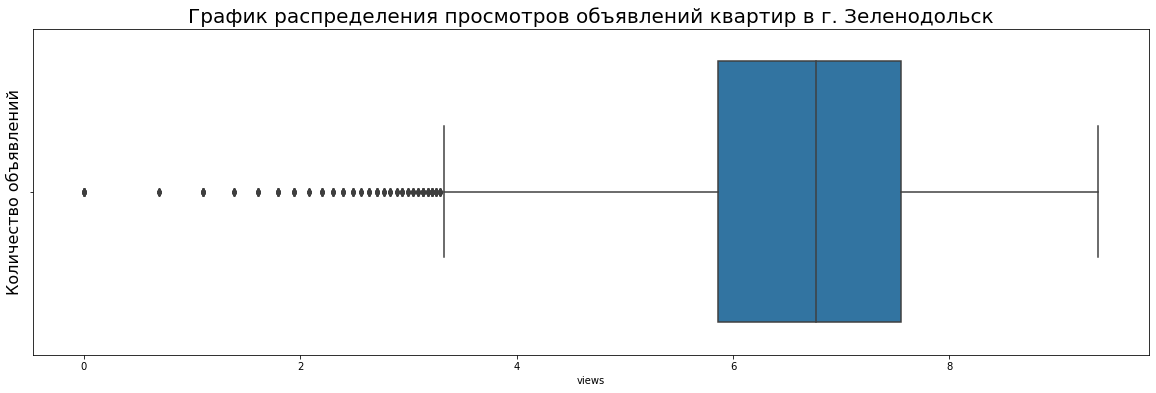

In [286]:
# график распределения стоимсоти продажи квартир в г. Зеленодольск после удаления выброса и корректировки стоимости
fig, ax = plt.subplots(figsize=(20,6))
sns.boxplot(x=np.log1p(as_history_df['views']))
ax.set_title('График распределения просмотров объявлений квартир в г. Зеленодольск', fontsize=20)
plt.ylabel('Количество объявлений', fontsize=16)
plt.show()

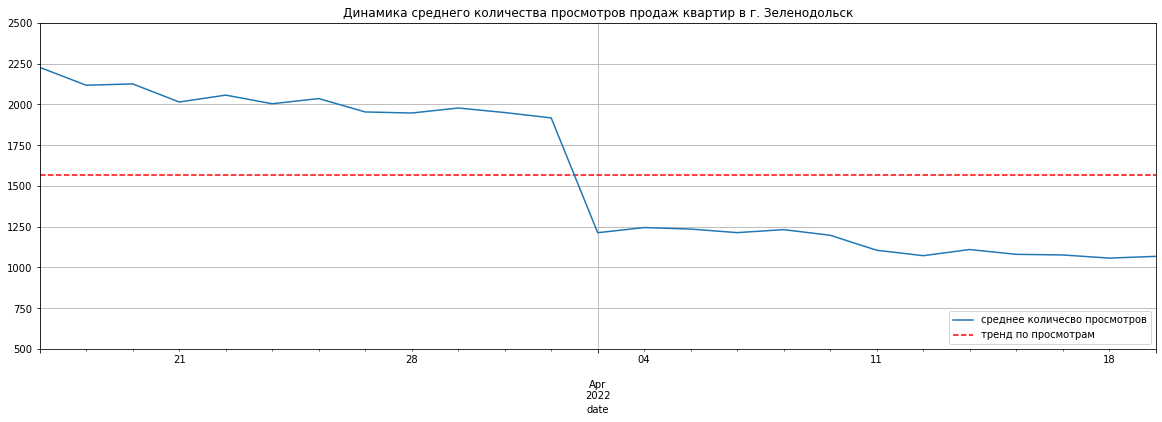

In [287]:
# график динамики количества просмотров 
fig, ax = plt.subplots(figsize=(20,6))

ax = as_history_df.groupby('date')['views'].mean().plot(grid=True, label = 'среднее количесво просмотров')

ax.set_title('Динамика среднего количества просмотров продаж квартир в г. Зеленодольск')

ax.hlines(as_history_df.groupby('date')['views'].mean().mean(), start_date, last_date, color = 'r', linestyle = '--', label = 'тренд по просмотрам')

ax.legend(loc = 'lower right')

plt.ylim(500,2500)

plt.show()

In [312]:
date(2022, 4, 1) - timedelta(days=1)

datetime.date(2022, 3, 31)

Можно сделать предположение - квартиры по объявлениям опубликованным ранее 01 апреля 2022 г. были проданы

## Проверка статистической гипотезы 

In [365]:
# количество просмотров 1 апреля 2022 г и в предыдущий день
bad_days_df = as_history_df[(as_history_df['date'].dt.date == date(2022, 4, 1)) | \
              (as_history_df['date'].dt.date == date(2022, 4, 1) - timedelta(days=1))]
bad_days_df.head()

,marker_id,price,val_id,views,date
11,600204697,1500000,1,1511,2022-03-31
12,600204697,1500000,1,887,2022-04-01
36,671949391,4970000,1,8036,2022-03-31
37,671949391,4970000,1,4320,2022-04-01
70,1291955154,4560000,1,9653,2022-03-31


In [366]:
# статистика просмотров 1 апреля 2022 г и в предыдущий день
bad_days_df.groupby('date')['views'].agg(['count', 'mean', 'min', 'max', 'std'])

,count,mean,min,max,std
date,,,,,
2022-03-31,437,"1,917.08",44,11091,"2,155.52"
2022-04-01,427,"1,212.99",13,7899,"1,375.06"


### Параметры теста:
* Двусторонний тест
* alpha = 0.05
* Критическое значение t-критерия: ±1.9667
* Критическая область: (-∞, -1.9667] ∪ [1.9667, ∞)

In [367]:
# функция проверки гипотезы
def hypothesis_check(p_value, t_critical):
    if abs(p_value) < t_critical:
        print('Отвергаем Н0. Разница между средними статистически значима.')
    else:
        print('Не удалось отвергнуть H0')
        
t_critical = 1.9667

In [368]:
# просморы 31 апреля 2022 г.
views_31_3_2022 = as_history_df[(as_history_df['date'].dt.date == date(2022, 3, 31))]['views']

In [369]:
# просморы 1 марта 2022 г.
views_1_4_2022 = as_history_df[(as_history_df['date'].dt.date == date(2022, 4, 1))]['views']

In [371]:
# t-тест
scipy.stats.ttest_ind(views_31_3_2022, views_1_4_2022, equal_var=False)

Ttest_indResult(statistic=5.737369106273981, pvalue=1.3999594684745318e-08)

In [372]:
# уровень значимости
p_value = scipy.stats.ttest_ind(views_31_3_2022, views_1_4_2022, equal_var=False)[-1]
p_value

1.3999594684745318e-08

In [374]:
# заключение
hypothesis_check(p_value, t_critical)

Отвергаем Н0. Разница между средними статистически значима.


## Кластерный анализ

In [381]:
as_history_df

,marker_id,price,val_id,views,date
0,389475304,2950000,1,344,2022-04-18
1,389475304,2950000,1,440,2022-04-19
2,600204697,1500000,1,1127,2022-03-17
3,600204697,1500000,1,1156,2022-03-18
4,600204697,1500000,1,1259,2022-03-21
...,...,...,...,...,...
11065,2412042716,2950000,1,127,2022-04-19
11066,2421241399,2499000,1,121,2022-04-18
11067,2421241399,2499000,1,138,2022-04-19
11068,2427327695,5500000,1,198,2022-04-18
